In [ ]:
# Import libraries
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Load MNIST data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
# Tiền xử lý dữ liệu, reshape từ ảnh xám 28*28 thành vector 784 chiều và đưa dữ liệu từ scale [0, 255] về [0, 1]
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [ ]:
# Số chiều noise vector
z_dim = 100

In [ ]:
# Optimizer
adam = Adam(learning_rate=0.0002, beta_1=0.5)
from keras.layers import LeakyReLU


# Mô hình Generator
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
# Vì dữ liệu ảnh MNIST đã chuẩn hóa về [0, 1] nên hàm G khi sinh ảnh ra cũng cần sinh ra ảnh có pixel value trong khoảng [0, 1] => hàm sigmoid được chọn
g.add(Dense(784, activation='sigmoid'))
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Mô hình Discriminator
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
# Hàm sigmoid cho bài toán binary classification
d.add(Dense(1, activation='sigmoid'))
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# Hàm vẽ loss function
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Hàm vẽ sample từ Generator
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Lưu giá trị loss và accuracy của Discriminator và Generator
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    # Tính số lần chạy trong mỗi epoch
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)

    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Lấy ngẫu nhiên các ảnh từ MNIST dataset (ảnh thật)
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Sinh ra noise ngẫu nhiên
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))

            # Dùng Generator sinh ra ảnh từ noise
            generated_images = g.predict(noise, verbose=0)
            X = np.concatenate((image_batch, generated_images))
            # Tạo label
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # gán label bằng 1 cho những ảnh từ MNIST dataset và 0 cho ảnh sinh ra bởi Generator

            # Train discriminator
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            # Khi train Generator gán label bằng 1 cho những ảnh sinh ra bởi Generator -> cố gắng lừa Discriminator.
            y2 = np.ones(BATCH_SIZE)
            # Khi train Generator thì không cập nhật hệ số của Discriminator.
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Lưu loss function
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Vẽ các số được sinh ra để kiểm tra kết quả
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 80
Batch size: 128
Batches per epoch: 468


<ipython-input-7-02be417b50ba>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(1, epochs+1)):


  0%|          | 0/80 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
1/1 [==============================] - 0s 64ms/step


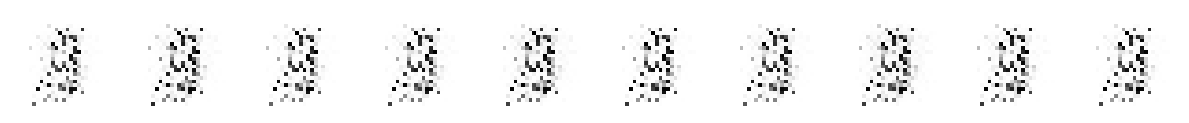

--------------- Epoch 20 ---------------
1/1 [==============================] - 0s 21ms/step


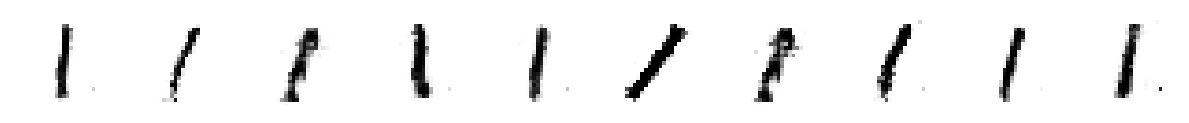

--------------- Epoch 40 ---------------
1/1 [==============================] - 0s 19ms/step


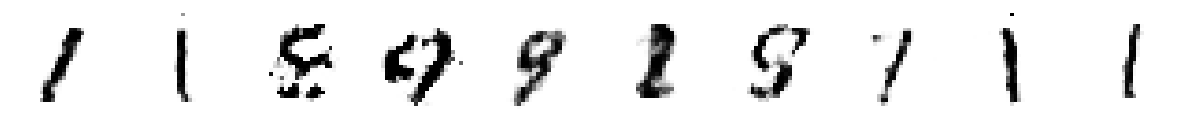

--------------- Epoch 60 ---------------
1/1 [==============================] - 0s 17ms/step


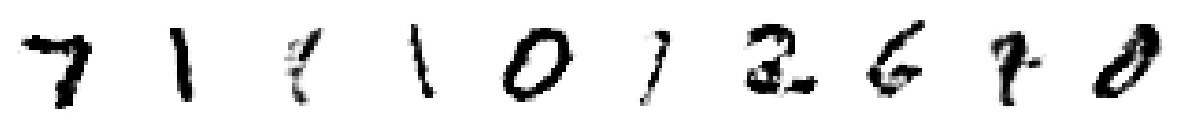

--------------- Epoch 80 ---------------
1/1 [==============================] - 0s 17ms/step


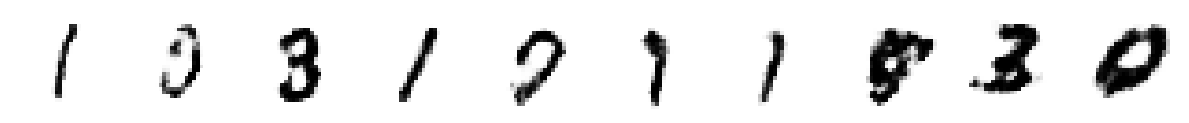

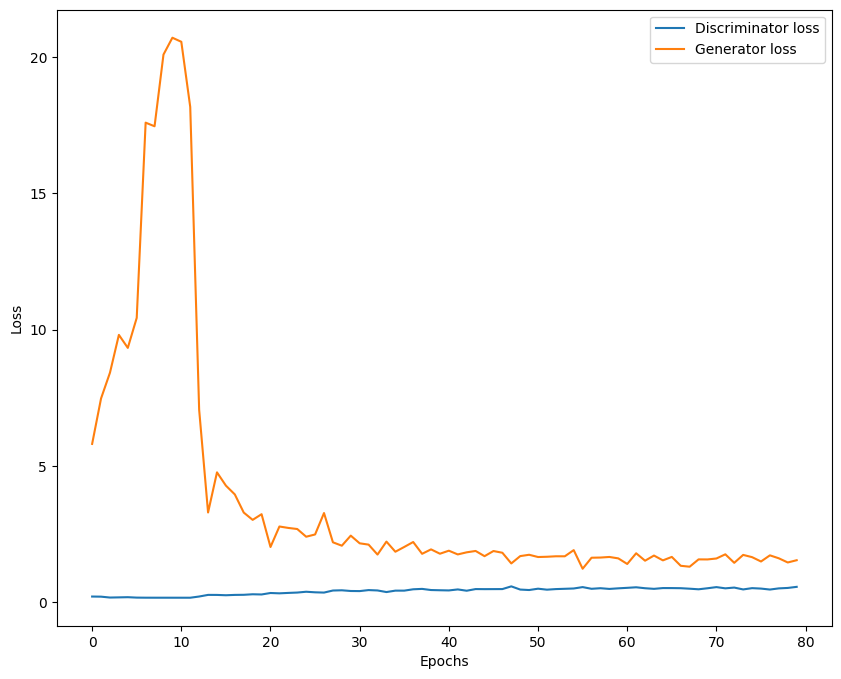

CPU times: user 48min 45s, sys: 2min 9s, total: 50min 54s
Wall time: 52min 32s


In [ ]:
%%time
train(epochs=80, plt_frq=20, BATCH_SIZE=128)

In [106]:
from tensorflow.keras.saving import load_model
from google.colab import drive
drive.mount('/content/drive')

gan = load_model('/content/drive/MyDrive/saved_model-80_epochs')
i = gan.get_layer('input_1')
g = gan.get_layer('sequential')
d = gan.get_layer('sequential_1')

gan.summary()
print('/\\'*40)
print(i)
print('/\\'*40)
g.summary()
print('/\\'*40)
d.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 784)               1486352   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\
Model: "sequenti

1/1 [==============================] - 0s 22ms/step


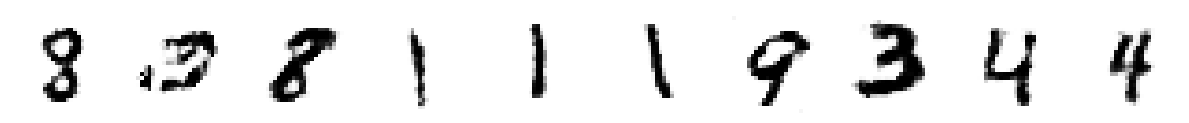

In [ ]:
plot_generated()

1/1 [==============================] - 0s 79ms/step


(array([[0.06067478]], dtype=float32), array([[0.06067478]], dtype=float32))

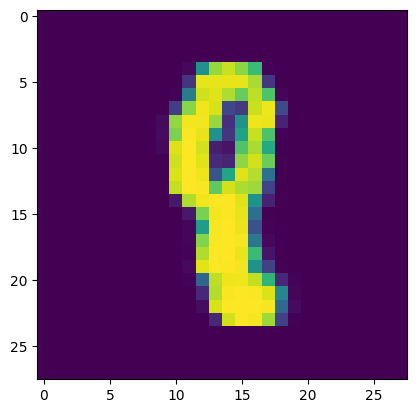

In [ ]:
noise = np.random.normal(0, 1, size=(1, z_dim))
gen_img = g.predict(noise)

plt.imshow(gen_img.reshape(28, 28))
d.predict(gen_img), gan.predict(noise)

32/32 [==============================] - 0s 2ms/step


(0.61259, 0.23114374)

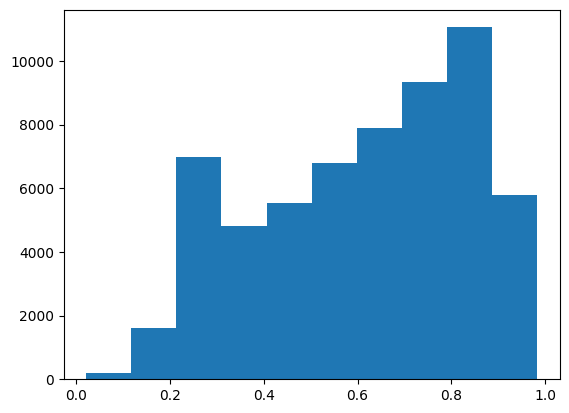

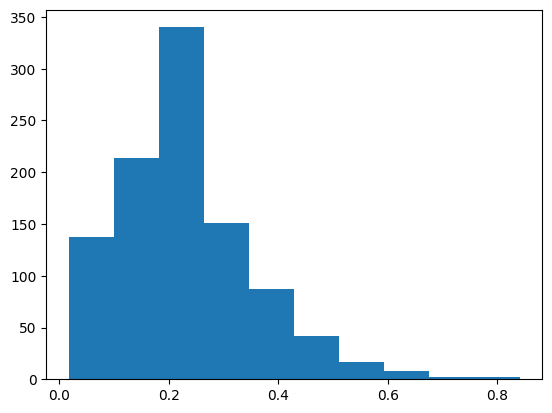

In [ ]:
pred_train = d.predict(X_train)
plt.hist(pred_train)

plt.figure()

pred_gen = gan.predict(np.random.normal(0, 1, size=(1000, z_dim)))
plt.hist(pred_gen)

pred_train.mean(), pred_gen.mean()

32/32 [==============================] - 0s 4ms/step


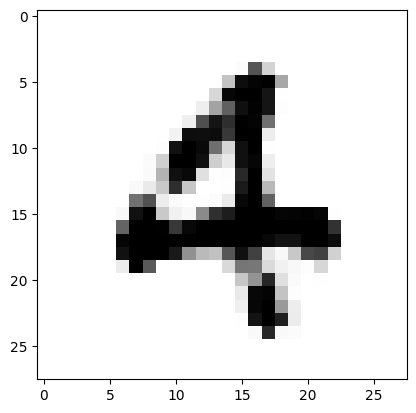

<Figure size 640x480 with 0 Axes>

In [ ]:
gan.predict(np.random.normal(0, 1, size=(1000, z_dim))).mean()
for i in range(1000):
  fake_img = g.predict(np.random.normal(0, 1, dsize=(1, z_dim)), verbose=0)
  if d.predict(fake_img, verbose=0) >= .8:
    plt.imshow(fake_img.reshape(28, 28), cmap='gray_r')
    plt.figure()